<a href="https://colab.research.google.com/github/SergeiVKalinin/BO_Research/blob/master/noise_GP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Variable noise GP algorithm

05/13/2024

* author `Boris Slautin`
* idea, supervision `Sergei Kalinin`
* gpax lib. `Maxim Ziatdinov`


In [1]:
!pip install -q git+https://github.com/ziatdinovmax/gpax

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Dict

import numpyro
import jax.numpy as jnp
import gpax

gpax.utils.enable_x64()

In [3]:
np.random.seed(1)

# Define the Forrester function
def forrester_function(x):
    return (6 * x - 2)**2 * np.sin(12 * x - 4)

def variable_noise(t, a, b,):
  return a/np.sqrt(t+0.5)+b

def cost_funct(t, d, e):
  return e*t + d

def target_sharp(t, a, b, d, e):
  return (abs(cost_funct(t, d, e)**2 - variable_noise(t, a, b)**2))**0.5

def target_smooth(t, a, b, d, e):
  return ((cost_funct(t, d, e) - variable_noise(t, a, b))**2)

def target_smooth1(t, a, b, d, e):
  return 10/jnp.exp((cost_funct(t, d, e) - variable_noise(t, a, b))**2)

Text(0.5, 1.0, 'Ground truth')

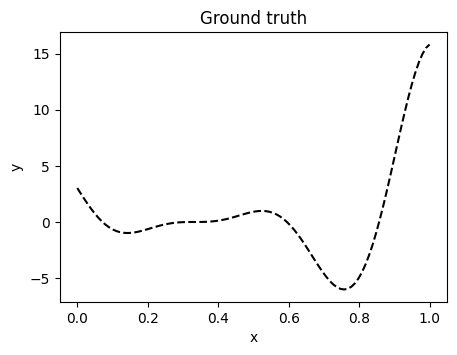

In [4]:
X = np.linspace(0,1,100)

_, ax = plt.subplots(figsize= (5,3.5), dpi=100)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.plot(X, forrester_function(X), '--', color='black')
plt.title('Ground truth')

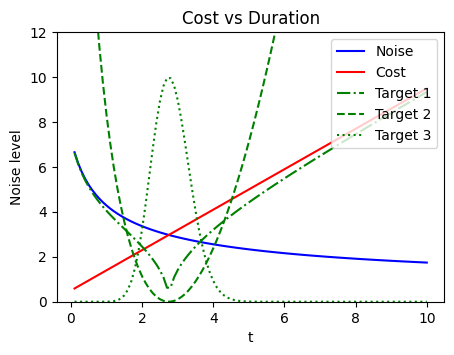

In [5]:
#visualise variable noise
a, b = 5, 0.2
d, e = 0.5, 0.9

dur = np.linspace(0.1, 10, 100)
noise = variable_noise(dur,a, b)
cost = cost_funct(dur, d, e)

_, ax = plt.subplots(figsize= (5,3.5), dpi=100)
ax.set_xlabel("t")
ax.set_ylabel("Noise level")
plt.plot(dur, noise, '-', color='b', label='Noise')
plt.plot(dur, cost,  '-', color='r', label='Cost')
plt.plot(dur, target_sharp(dur, a, b, d, e),  '-.', c='g', label='Target 1')
plt.plot(dur, target_smooth(dur, a, b, d, e), '--', c='g', label='Target 2')
plt.plot(dur, target_smooth1(dur, a, b, d, e), linestyle='dotted', c='g', label='Target 3')

plt.title('Cost vs Duration')
plt.ylim(0,12)
plt.legend(loc='upper right')

Target 3 was found to be an optimal choice for the noise sGP.

In [6]:
arg_opt_t = np.argmax(target_sharp(dur, a, b, d, e))
opt_t = dur[arg_opt_t]
print(f'Optimal measurement duration for a = {a} and b = {b}: {round(opt_t,2)}')

Optimal measurement duration for a = 5 and b = 0.2: 10.0


In [10]:
#@title GP step functions
def NoiseGP_step(X, x, y, y_noise, ind_to_remove, verbose=True):
  if len(ind_to_remove) > 0:
    x_filt       = np.delete(x, ind_to_remove)
    y_filt       = np.delete(y, ind_to_remove)
    y_noise_filt = np.delete(y_noise, ind_to_remove)
  else:
    x_filt, y_filt, y_noise_filt = x.copy(), y.copy(), y_noise.copy()

  key1, key2 = gpax.utils.get_keys()
  model = gpax.MeasuredNoiseGP(1, "Matern")
  model.fit(key1, x_filt, y_filt, y_noise_filt)

  y_pred, y_sampled = model.predict(key2, X, noise_prediction_method='gpreg', n=100)

  acq = gpax.acquisition.UE(key2, model, X, noiseless=True)
  idx = acq.argmax()

  # Plot observed points, mean prediction, and acqusition function
  lower_b = y_pred - y_sampled.std(axis=(0,1))
  upper_b = y_pred + y_sampled.std(axis=(0,1))

  if verbose:
    # Plot results
    fig, axs = plt.subplots(2, 1, figsize=(7, 3), sharex=True)

    ax1 = axs[0]
    ax2 = axs[1]

    ax1.errorbar(x_filt, y_filt, yerr=np.sqrt(y_noise_filt), fmt='o', color='black', ecolor='red',
                alpha=0.7, elinewidth=2, capsize=1, label='Observations', zorder=2)
    if len(ind_to_remove) > 0:
      ax1.errorbar(x[ind_to_remove], y[ind_to_remove], yerr=np.sqrt(y_noise[ind_to_remove]),
                  fmt='o', color='black', ecolor='grey',
                  alpha=0.7, elinewidth=2, capsize=1, label='Excluded Observations', zorder=2)
    ax1.plot(X, y_pred, lw=1, c='b', label='Posterior mean')
    ax1.fill_between(
        X,
        lower_b,
        upper_b,
        color='blue',
        alpha=0.3,
        linewidth=0,
        label="Model uncertainty",)
    ax1.set_title('Exploring function')
    ax1.set_ylabel('y')


    ax2.plot(X, acq, lw=2, c='orangered', label='Acquisition function')
    ax2.scatter(
        X[idx],
        acq[idx],
        s=30,
        marker="o",
        color="black",
        label='Next point to measure',
        zorder=3,)
    ax2.set_ylabel('UE acq.')

    plt.subplots_adjust(hspace=0.1)
    plt.xlabel('x')
    plt.legend()
    plt.show()

  return X[idx], (y_pred, y_sampled)


def sGP_step(dur, t, noise_targ, e, d, verbose=True):

  def mean_function(t: jnp.ndarray, params: Dict[str, float]) -> jnp.ndarray:
    return target_sharp(t, params['a'], params['b'], d, e)

  def priors():
    # Sample model parameters
    a = numpyro.sample("a", numpyro.distributions.Uniform(0, 20))
    b = numpyro.sample("b", numpyro.distributions.Uniform(0, 1))
    # Return sampled parameters as a dictionary
    return {'a': a, 'b': b}

  key1, key2 = gpax.utils.get_keys()
  gp_model = gpax.ExactGP(1, kernel='Matern', mean_fn=mean_function, mean_fn_prior=priors)
  gp_model.fit(key1, t, noise_targ)

  t_pred, t_sampled = gp_model.predict(key2, dur, n=100)

  acq = gpax.acquisition.UCB(key2, gp_model, dur, noiseless=True, maximize=False, beta=10)
  idx = acq.argmax()

  if verbose:
    # Plot results
    fig, ax = plt.subplots(2, 1, figsize=(7, 3), sharex=True)

    ax[1].set_xlabel("$t$")
    ax[0].set_ylabel("Noise")
    ax[1].set_ylabel("UCB acq.")

    ax[0].scatter(t, noise_targ, marker='o', c='k', zorder=1, label="Noisy observations")

    lower_b = t_pred - t_sampled.std(axis=(0,1))
    upper_b = t_pred + t_sampled.std(axis=(0,1))

    ax[0].fill_between(
            dur,
            lower_b,
            upper_b,
            color='r',
            alpha=0.3,
            linewidth=0,
            label="Model uncertainty",)

    ax[0].plot(dur, t_pred, lw=1, zorder=1, c='r', label='Posterior mean')
    ax[0].set_title('Noise vs Duration')

    ax[1].plot(dur, acq, lw=2, c='orangered', label='Acquisition function')
    ax[1].scatter(
        dur[idx],
        acq[idx],
        s=30,
        marker="o",
        color="black",
        label='Next point to measure',
        zorder=3,)

    plt.subplots_adjust(hspace=0.1)
    plt.legend()

    plt.show()
  return dur[idx], (t_pred, t_sampled)


------------------ iter 0 -------------------



sample: 100%|██████████| 4000/4000 [00:08<00:00, 468.73it/s, 3 steps of size 9.56e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.76      2.47      1.03      0.06      3.85   1427.94      1.00
    k_scale      1.40      1.68      0.88      0.05      3.08   1385.94      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



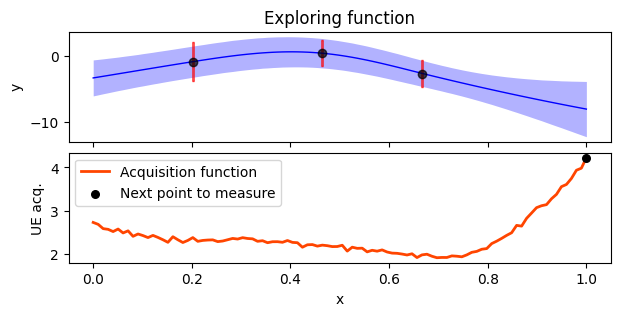

sample: 100%|██████████| 4000/4000 [00:10<00:00, 399.83it/s, 23 steps of size 1.09e-01. acc. prob=0.83] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      3.56      2.00      3.46      0.17      6.25    923.16      1.00
          b      0.49      0.29      0.49      0.03      0.92   1231.15      1.00
k_length[0]      1.73      2.29      1.07      0.09      3.78   1406.71      1.00
    k_scale      0.88      1.12      0.56      0.04      1.76   1000.77      1.00
      noise      0.83      0.93      0.55      0.05      1.80    958.14      1.00



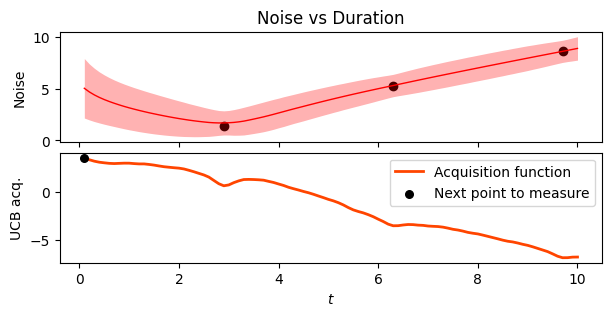


------------------ iter 1 -------------------



sample: 100%|██████████| 4000/4000 [00:04<00:00, 854.14it/s, 3 steps of size 8.58e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.48      2.18      0.84      0.02      3.36   1557.45      1.00
    k_scale      2.02      3.16      1.07      0.02      4.35   1121.12      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



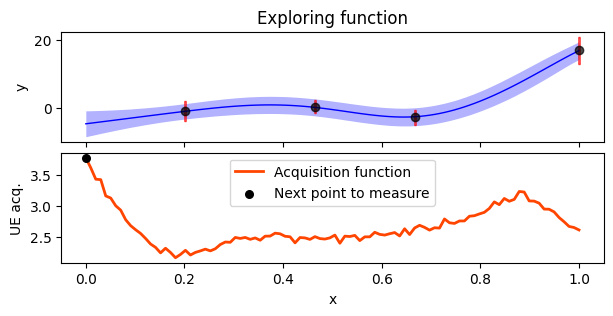

sample: 100%|██████████| 4000/4000 [00:05<00:00, 724.81it/s, 7 steps of size 3.61e-01. acc. prob=0.84]  



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      4.77      0.87      4.78      3.32      6.14   1051.60      1.00
          b      0.48      0.29      0.47      0.01      0.89   1375.26      1.00
k_length[0]      1.91      2.73      1.07      0.05      4.36   1061.70      1.00
    k_scale      0.75      0.84      0.50      0.05      1.56   1169.99      1.00
      noise      0.69      0.72      0.47      0.05      1.47    933.05      1.00



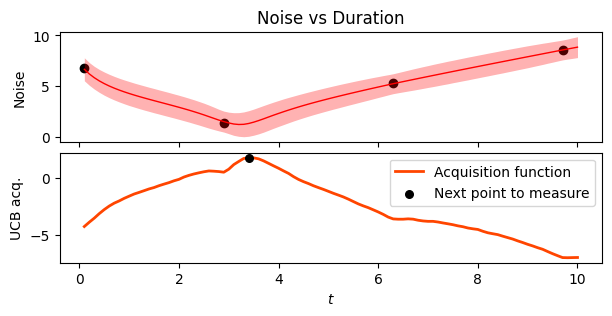


------------------ iter 2 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 764.23it/s, 3 steps of size 8.61e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.56      2.37      0.85      0.04      3.74   1177.88      1.00
    k_scale      2.03      3.11      1.10      0.04      4.43   1053.81      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



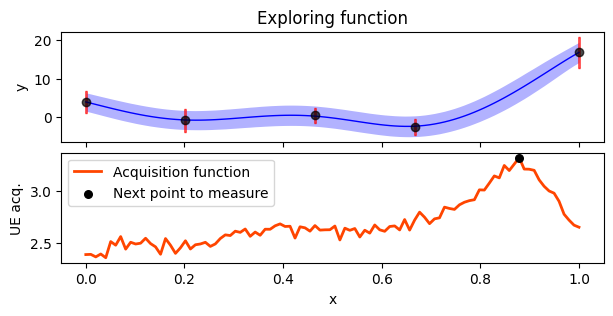

sample: 100%|██████████| 4000/4000 [00:06<00:00, 612.11it/s, 15 steps of size 1.71e-01. acc. prob=0.85] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      4.83      0.81      4.85      3.58      6.13    378.64      1.01
          b      0.47      0.29      0.44      0.00      0.89    812.48      1.00
k_length[0]      1.95      2.91      1.11      0.03      4.32   1119.71      1.00
    k_scale      0.67      0.71      0.44      0.04      1.42    760.75      1.00
      noise      0.59      0.59      0.41      0.02      1.27    822.02      1.00



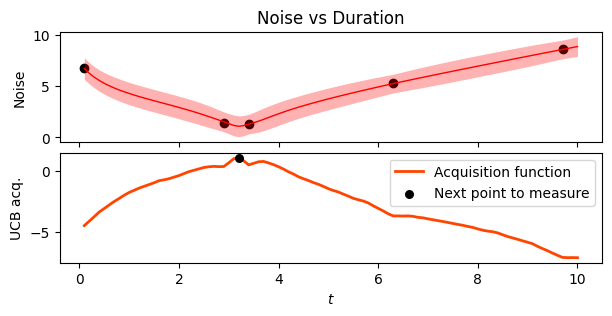


------------------ iter 3 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 768.31it/s, 3 steps of size 9.03e-01. acc. prob=0.88] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.50      2.08      0.82      0.05      3.51   1108.90      1.00
    k_scale      2.14      2.79      1.27      0.03      4.92   1320.15      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



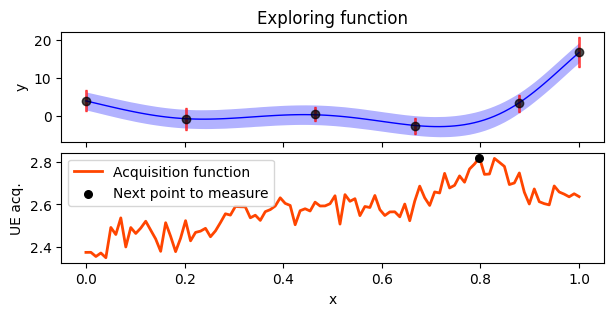

sample: 100%|██████████| 4000/4000 [00:07<00:00, 548.88it/s, 63 steps of size 5.88e-02. acc. prob=0.82] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      4.81      0.67      4.81      3.72      5.72    517.27      1.00
          b      0.45      0.28      0.42      0.01      0.85    692.38      1.00
k_length[0]      2.02      2.65      1.15      0.04      4.49    889.82      1.00
    k_scale      0.58      0.62      0.38      0.02      1.23    543.25      1.00
      noise      0.45      0.47      0.31      0.03      0.97    590.20      1.00



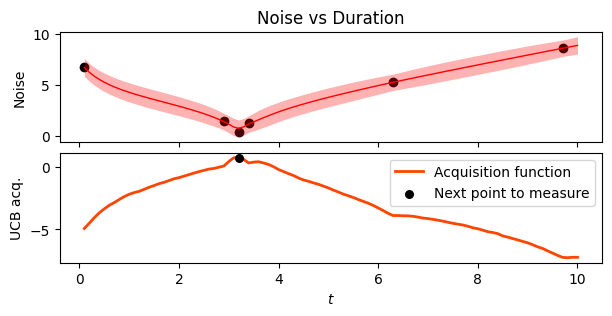


------------------ iter 4 -------------------



sample: 100%|██████████| 4000/4000 [00:04<00:00, 803.52it/s, 3 steps of size 8.62e-01. acc. prob=0.87] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.50      2.62      0.79      0.04      3.51   1755.97      1.00
    k_scale      1.91      2.93      1.06      0.02      4.32   1105.16      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



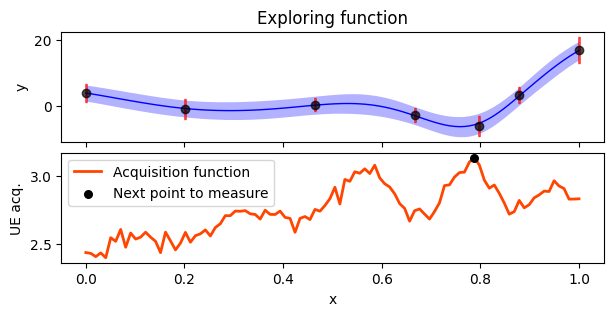

sample: 100%|██████████| 4000/4000 [00:12<00:00, 327.20it/s, 255 steps of size 1.33e-02. acc. prob=0.86]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      4.84      0.55      4.86      3.87      5.58    475.11      1.00
          b      0.43      0.26      0.41      0.00      0.82    518.48      1.00
k_length[0]      2.50      3.31      1.29      0.06      6.24    620.67      1.00
    k_scale      0.50      0.54      0.33      0.02      1.07    753.06      1.00
      noise      0.29      0.32      0.19      0.02      0.65    531.25      1.00



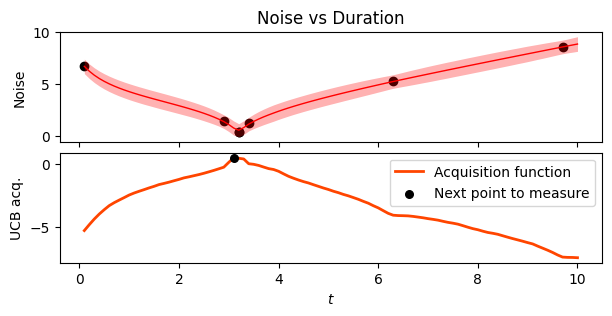


------------------ iter 5 -------------------



sample: 100%|██████████| 4000/4000 [00:06<00:00, 653.51it/s, 3 steps of size 6.34e-01. acc. prob=0.89] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.12      1.80      0.51      0.02      2.69    970.67      1.00
    k_scale      2.82      4.57      1.17      0.05      7.43    508.63      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



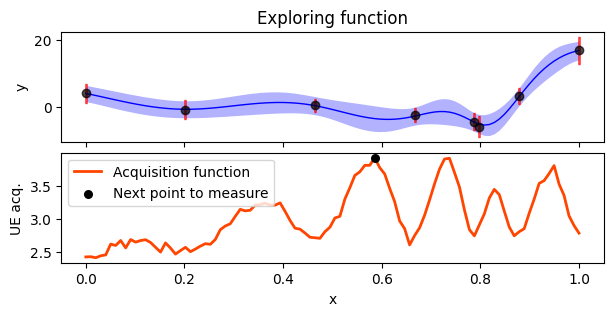

sample: 100%|██████████| 4000/4000 [00:11<00:00, 357.78it/s, 127 steps of size 2.30e-02. acc. prob=0.79]



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
          a      4.81      0.55      4.85      3.91      5.61    282.00      1.00
          b      0.44      0.26      0.41      0.00      0.82    487.08      1.00
k_length[0]      2.55      3.62      1.35      0.13      5.97    680.74      1.00
    k_scale      0.46      0.50      0.31      0.03      1.02    505.08      1.00
      noise      0.22      0.25      0.15      0.01      0.47    229.66      1.00



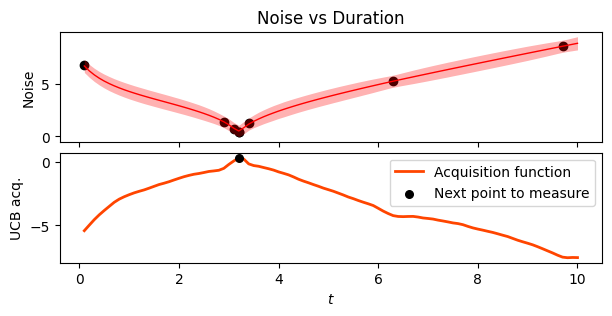


------------------ iter 6 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 777.93it/s, 7 steps of size 7.10e-01. acc. prob=0.86] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      1.31      2.41      0.63      0.01      3.06   1004.40      1.00
    k_scale      2.36      4.04      1.09      0.03      5.47    731.08      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



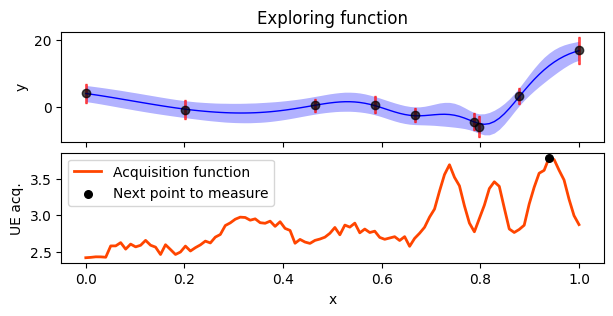

Noise GP already converged. Optimal duration: 3.18

------------------ iter 7 -------------------



sample: 100%|██████████| 4000/4000 [00:06<00:00, 664.42it/s, 3 steps of size 3.59e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.43      0.99      0.13      0.01      1.09    335.10      1.01
    k_scale      8.40      8.31      6.22      0.07     18.62    549.72      1.01
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



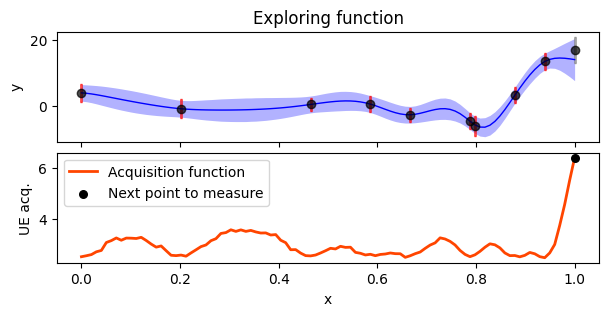

Noise GP already converged. Optimal duration: 3.17

------------------ iter 8 -------------------



sample: 100%|██████████| 4000/4000 [00:06<00:00, 633.49it/s, 7 steps of size 7.86e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.13      0.04      0.12      0.07      0.21   1256.74      1.00
    k_scale     20.32     10.79     17.81      5.58     34.38   1234.84      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



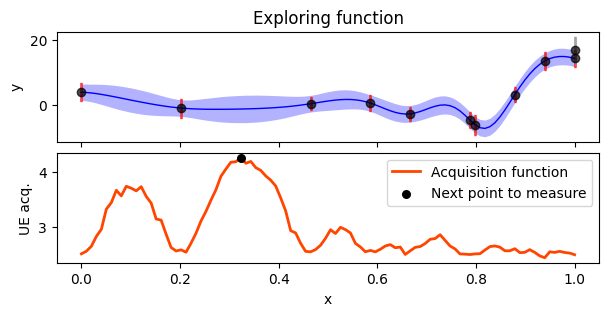

Noise GP already converged. Optimal duration: 3.16

------------------ iter 9 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 783.62it/s, 3 steps of size 7.22e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.13      0.05      0.13      0.06      0.20   1345.55      1.00
    k_scale     19.46     10.61     16.96      5.10     33.29   1211.73      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



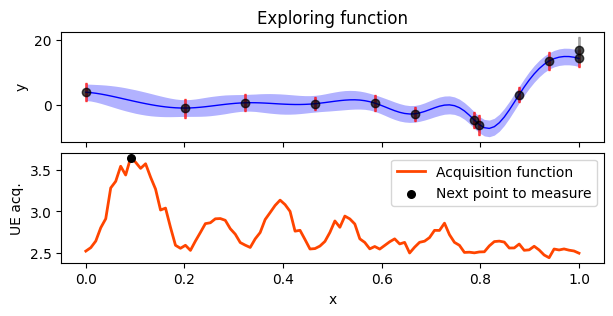

Noise GP already converged. Optimal duration: 3.18

------------------ iter 10 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 782.90it/s, 7 steps of size 7.99e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.05      0.13      0.06      0.21   1267.36      1.00
    k_scale     18.44     10.36     16.00      4.95     31.90   1175.16      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



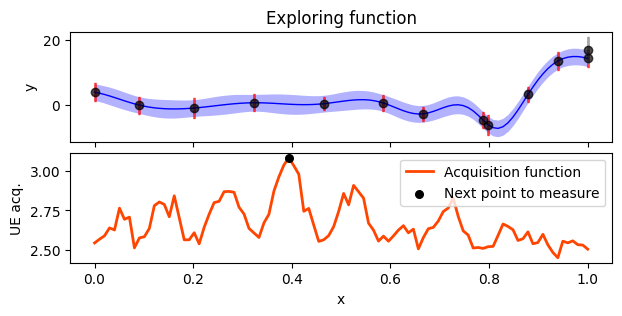

Noise GP already converged. Optimal duration: 3.17

------------------ iter 11 -------------------



sample: 100%|██████████| 4000/4000 [00:04<00:00, 814.10it/s, 7 steps of size 7.95e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.05      0.13      0.07      0.21   1279.43      1.00
    k_scale     18.30     10.13     16.04      5.49     32.23   1156.65      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



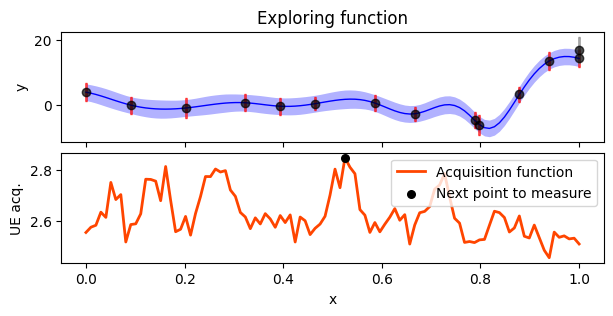

Noise GP already converged. Optimal duration: 3.17

------------------ iter 12 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 766.10it/s, 3 steps of size 7.08e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.05      0.13      0.06      0.21   1048.02      1.00
    k_scale     18.82     10.69     16.12      4.30     32.34    863.39      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



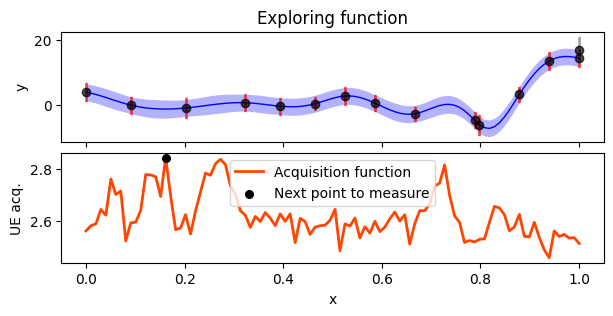

Noise GP already converged. Optimal duration: 3.17

------------------ iter 13 -------------------



sample: 100%|██████████| 4000/4000 [00:04<00:00, 822.94it/s, 3 steps of size 7.38e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.05      0.13      0.07      0.21   1165.25      1.00
    k_scale     18.01     10.04     15.66      4.96     31.77   1152.32      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



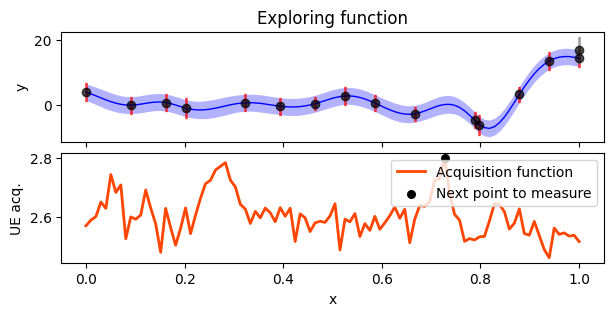

Noise GP already converged. Optimal duration: 3.17

------------------ iter 14 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 791.28it/s, 3 steps of size 6.51e-01. acc. prob=0.93] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.04      0.13      0.07      0.20   1119.99      1.00
    k_scale     20.30     10.82     17.74      6.77     34.19    822.25      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



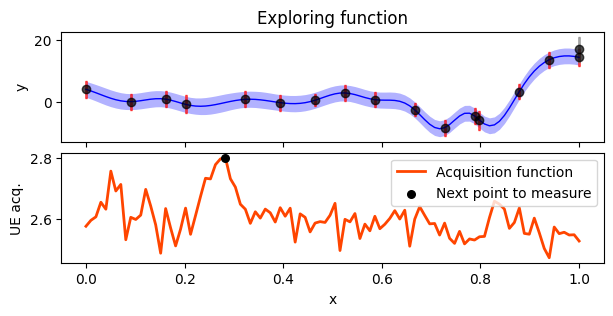

Noise GP already converged. Optimal duration: 3.17

------------------ iter 15 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 779.02it/s, 3 steps of size 6.70e-01. acc. prob=0.92] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.04      0.13      0.07      0.20   1115.45      1.00
    k_scale     20.08     10.79     17.50      6.97     35.69    861.78      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



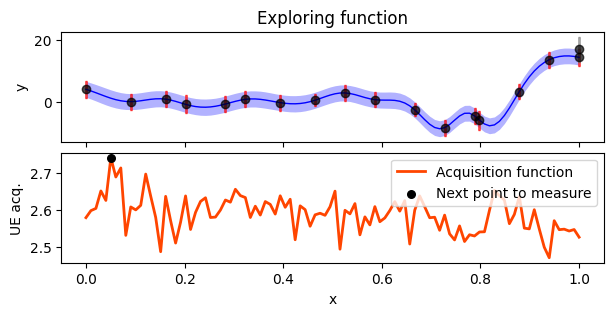

Noise GP already converged. Optimal duration: 3.17

------------------ iter 16 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 726.66it/s, 7 steps of size 6.95e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.04      0.13      0.07      0.20   1028.40      1.00
    k_scale     19.83     10.90     17.14      5.82     33.67    901.03      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



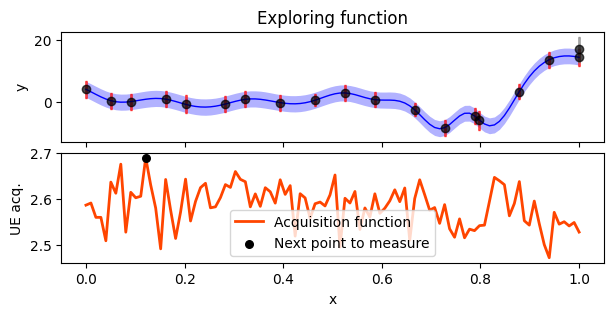

Noise GP already converged. Optimal duration: 3.17

------------------ iter 17 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 747.17it/s, 7 steps of size 7.10e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.04      0.13      0.07      0.20   1042.78      1.00
    k_scale     19.86     10.98     17.21      5.58     33.37    901.54      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



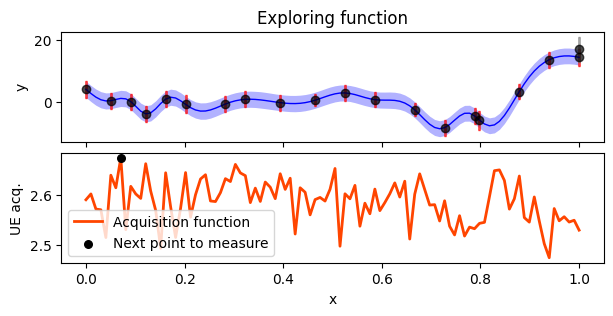

Noise GP already converged. Optimal duration: 3.17

------------------ iter 18 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 698.23it/s, 9 steps of size 7.57e-01. acc. prob=0.90] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.04      0.13      0.07      0.20    982.75      1.00
    k_scale     20.14     11.21     17.46      5.74     34.11    836.19      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



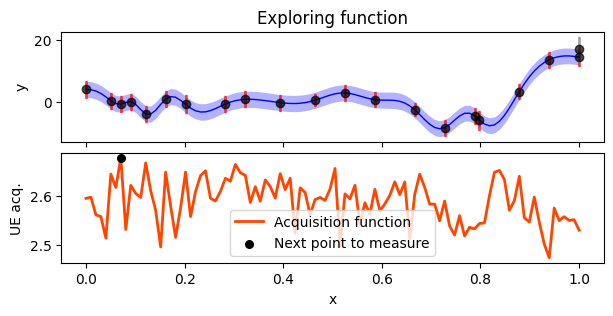

Noise GP already converged. Optimal duration: 3.17

------------------ iter 19 -------------------



sample: 100%|██████████| 4000/4000 [00:05<00:00, 689.71it/s, 3 steps of size 7.12e-01. acc. prob=0.91] 



                 mean       std    median      5.0%     95.0%     n_eff     r_hat
k_length[0]      0.14      0.04      0.13      0.07      0.20   1065.32      1.00
    k_scale     19.88     11.02     17.26      5.54     33.48    908.76      1.00
      noise      0.00      0.00      0.00      0.00      0.00       nan       nan



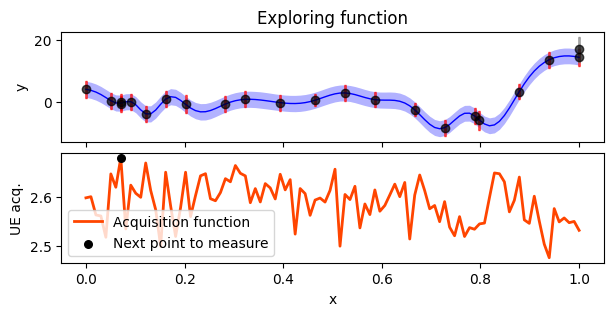

Noise GP already converged. Optimal duration: 3.17


In [13]:
#ground truth noise params
a = 5
b = 0.3

#known cost params
d = 0.05
e = 0.9

#Experiment params
num_measurements = 20  # Number of measurements per x
num_measurements_conv = 3  # Number of measurements per x after convergence
num_iteration = 20      # Number of exploration steps
num_seeds = 3          # Number of seed points

#params for duration convergence
conv_tail = 4          #the length of tail to assess convergence of noise GP
var_tresh = 0.1        #t variation threshold

#params to filter points
x_dist_thresh = 0.1
noise_ratio_thresh = 2

X = np.linspace(0,1,100)
dur = np.linspace(0.1, 10, 100)

#effective cost function
cost = cost_funct(dur, d, e)

#seeds
x = np.random.choice(X, size=num_seeds, replace=True)
t = np.random.choice(dur, size=num_seeds, replace=False)
y_measurements = np.array([forrester_function(x[i]) + np.random.normal(0, variable_noise(t[i], a, b), num_measurements) for i in range(len(x))])

# Calculate mean and variance for Y measurements at each X
y = np.mean(y_measurements, axis=1)
y_noise = np.var(y_measurements, axis=1)

noise_targ = target_sharp(t, a, b, d, e)
ind_to_remove = np.array([])

for iter in range(num_iteration):
  print(f'\n------------------ iter {iter} -------------------\n')
  #an exclusion of the noisy points if we measure nearby with much higher precision
  dists = abs(x - x[-1])
  new_inds = np.where((dists < x_dist_thresh) & (y_noise > noise_ratio_thresh*y_noise[-1]))[0]
  ind_to_remove = np.unique(np.append(ind_to_remove, new_inds)).astype(int)

  next_x, (y_pred, y_sampled) = NoiseGP_step(X, x, y, y_noise, ind_to_remove, verbose=True)
  if np.std(t[-conv_tail:]) > var_tresh:
    next_t, (t_pred, t_sampled) = sGP_step(dur, t, noise_targ, e, d, verbose=True)
    next_y_meas = np.array([forrester_function(next_x) + np.random.normal(0, variable_noise(next_t, a, b), num_measurements)])
    y = np.append(y, np.mean(next_y_meas, axis=1))
    y_noise = np.append(y_noise, np.var(next_y_meas, axis=1))
  else:
    next_t = np.mean(t[-conv_tail:])
    next_y_meas = np.array([forrester_function(next_x) + np.random.normal(0, variable_noise(next_t, a, b), num_measurements_conv)])
    y = np.append(y, np.mean(next_y_meas))
    y_noise = np.append(y_noise, np.mean(y_noise[-conv_tail:]))
    print(f'Noise GP already converged. Optimal duration: {round(next_t,2)}')

  t = np.append(t, next_t)
  x = np.append(x, next_x)


  noise_targ = target_sharp(t, a, b, d, e)

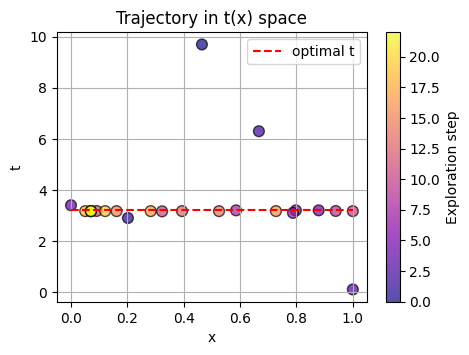

In [14]:
arg_opt_t = np.argmax(target_smooth1(dur, a, b, d, e))
opt_t = dur[arg_opt_t]

fig, ax = plt.subplots(figsize=(5, 3.5))

sc=plt.scatter(x,
              t,
              s=60,
              cmap='plasma',
              c = np.arange(len(x)),
              edgecolor='black',
              alpha=0.7)

cbar_sc = fig.colorbar(sc, ax=ax, label="Exploration step")

plt.hlines(opt_t, 0, 1, linestyles='--', color='red', label='optimal t')

plt.title('Trajectory in t(x) space')
plt.xlabel('x')
plt.ylabel('t')
plt.legend()

plt.grid()